In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
from pandas import DataFrame
warnings.filterwarnings("ignore")
%matplotlib inline

        
def time_series_plot(df):
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for p in ['D', 'M', 'Y']:
                if p=='D':
                    print("Plotting daily data")
                elif p=='M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).sum()
                    ax = __T[[col_num]].plot()
                    ax.set_ylim(bottom=0)
                    ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.show()

                    
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()
    
    # Plot the pairwise joint distributions
    print("\nTo check pairwise joint distribution of numeric data")
    if hue==None:
        sns.pairplot(df.select_dtypes(include=np.number))
    else:
        sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
    plt.show()


def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")
    
    
def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()
    

def eda(df):
    """Given dataframe, generate exploratory data analysis"""
    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")
        
    # replace field that's entirely space (or empty) with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print("Preview of data:")
    display(df.head(3))

    print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
    print(df.info())

    # generate preview of entries with null values
    if df.isnull().any(axis=None):
        print("\nPreview of data with null values:")
        display(df[df.isnull().any(axis=1)].head(3))
        missingno.matrix(df)
        plt.show()

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")

    # EDA of categorical data
    categorical_eda(df)
    
    # EDA of numeric data
    numeric_eda(df)
        
    # Plot time series plot of numeric data
    time_series_plot(df)

In [2]:
import pandas as pd
import re

def wrangle_with_dt(filepath):
    """
    Wrangle function takes an input of a filepath which contains a date-time,
    outputs a cleaned dataframe
    """
    # Reads in DF from filepath using Pandas
    df = pd.read_csv(filepath, parse_dates=['Fiscal Year Start', 'Fiscal Year End'])
    
    # Seperates the categorical columns
    categorical_cols = df.select_dtypes('object').columns
    
    #Creates threshold for how many times you will allow the same value to show up in multiple columns in a row.
    threshold = 50
    
    #Identify high cardinality columns
    high_card_cols = [col for col in categorical_cols 
                      if df[col].nunique() > threshold]
    
    # Drop high cardinality columns
    df.drop(high_card_cols, axis=1, inplace=True)
    
    # Drop columns with a high number of NaN values
    if len(df) > 100:
        df = df.dropna(axis = 1, thresh = 100)
    # Fill NA values with front fill. Replaces with value ahead of it.
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    
    # Clear punctuation/special characters from columns using regex
    punct_regex = r"[^0-9a-zA-Z\s]"
    special_char_regex = r'[\$\%\&\@+\"\'\,]'
    df.columns = df.columns.str.replace('[?]', '')
    df.columns = df.columns.str.replace(r'[/,\\]', ' ')
    # Lambda apply regex to df
    df = df.rename(columns = lambda x: 
        re.sub(punct_regex, "", x))
    df = df.rename(columns = lambda x:
        re.sub(special_char_regex, "", x))
    
    # Replace all spaces with an underscore for proper formatting
    df = df.rename(columns = lambda x:
        x.replace(" ", "_"))
    
    # Case normalize column names
    df.columns = df.columns.str.lower()
    
    return df

def wrangle_without_dt(filepath):
    """
    Wrangle function takes an input of a filepath which does not contains a date-time,
    outputs a cleaned dataframe
    """
    # Reads in DF from filepath using Pandas
    df = pd.read_csv(filepath)
    
    # Seperates the categorical columns
    categorical_cols = df.select_dtypes('object').columns
    
    #Creates threshold for how many times you will allow the same value to show up in multiple columns in a row.
    threshold = 50
    
    #Identify high cardinality columns
    high_card_cols = [col for col in categorical_cols 
                      if df[col].nunique() > threshold]
    
    # Drop high cardinality columns
    df = df.drop(high_card_cols, axis=1)
    
    # Drop columns with a high number of NaN values
    if len(df) > 100:
        df = df.dropna(axis = 1, thresh = 100)
    # Fill NA values with front fill. Replaces with value ahead of it.
    # Replaces values at start of data with last 
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    
    # Clear punctuation/special characters from columns using regex
    punct_regex = r"[^0-9a-zA-Z\s]"
    #special_char_regex = r'[\$\%\&\@+\"\'\,]'
    df.columns = df.columns.str.replace('[?]', '')
    df.columns = df.columns.str.replace(r'[/,\\]', ' ')
    # Lambda apply regex to df
    df = df.rename(columns = lambda x: 
        re.sub(punct_regex, "", x))
    #df = df.rename(columns = lambda x:
       # re.sub(special_char_regex, "", x))
    
    # Replace all spaces with an underscore for proper formatting
    df = df.rename(columns = lambda x:
        x.replace(" ", "_"))
    
    # Case normalize column names
    df.columns = df.columns.str.lower()
    
    return df

In [3]:
df = pd.read_csv(r'saber_combined_all_fields.csv')

In [4]:
df.head()

,Unnamed: 0,estu_tipodocumento,estu_nacionalidad,estu_genero,estu_fechanacimiento,estu_exterior,periodo,estu_consecutivo,estu_estadocivil,estu_estudiante,...,punt_biologia,punt_quimica,punt_fisica,punt_ciencias_sociales,punt_filosofia,punt_ingles,desemp_ingles,profundiza,puntaje_prof,desemp_prof
0,0,TI,COLOMBIA,M,30/07/1996,NaN,20134,EK201340233804,Soltero,ESTUDIANTE,...,39.0,42.0,33.0,33.0,29.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,49.0,NaN
1,1,CC,COLOMBIA,M,13/04/1994,NaN,20133,EK201330220754,Soltero,ESTUDIANTE,...,52.0,52.0,54.0,44.0,47.0,51.0,A1,PUNT_PROFUNDIZA_LENGUAJE,6.0,II
2,2,CC,COLOMBIA,F,08/12/1991,NaN,20134,EK201340246502,Soltero,ESTUDIANTE,...,50.0,51.0,28.0,46.0,45.0,43.0,A-,PUNT_PROFUNDIZA_BIOLOGIA,5.0,I
3,3,TI,COLOMBIA,F,10/01/1996,NaN,20134,EK201340237996,Soltero,ESTUDIANTE,...,34.0,35.0,45.0,42.0,40.0,43.0,A-,PUNT_INTERDISC_VIOLENCIAYSOC,29.0,NaN
4,4,CC,COLOMBIA,M,11/10/1995,NO,20173,EK201730119521,NaN,ESTUDIANTE,...,57.0,65.0,44.0,49.0,43.0,42.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,55.0,NaN


In [5]:
df.isnull().sum()

Unnamed: 0                   0
estu_tipodocumento           0
estu_nacionalidad            0
estu_genero                  3
estu_fechanacimiento       121
                         ...  
punt_ingles                  0
desemp_ingles               22
profundiza                   0
puntaje_prof                 0
desemp_prof             114055
Length: 144, dtype: int64

In [6]:
df.shape

(212010, 144)

# Let's Translate the Headers

In [7]:
import ast
pd.set_option('display.max_rows', 750)

# open the file using open
file = open(r"headers.txt", "r")
contents = file.read()
file.close()

# now we will take all those headers in the form of dictionary 
my_headers = ast.literal_eval(contents)

# let's converts those heading into lower case as the headers are saved in capital in the txt file
my_headers_low = ast.literal_eval(contents.lower()) 

# now let's convert the headers
df = df.rename(columns=my_headers_low)#, inplace=True)

In [8]:
df.head()

,Unnamed: 0,your_type_of_document,your_nationality,your_gender,your_birthdate,your_exterior,period,your_consecutive,your_marital_status,your_student,...,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,performance_english,go_deep,score_prof,performance_prof
0,0,TI,COLOMBIA,M,30/07/1996,NaN,20134,EK201340233804,Soltero,ESTUDIANTE,...,39.0,42.0,33.0,33.0,29.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,49.0,NaN
1,1,CC,COLOMBIA,M,13/04/1994,NaN,20133,EK201330220754,Soltero,ESTUDIANTE,...,52.0,52.0,54.0,44.0,47.0,51.0,A1,PUNT_PROFUNDIZA_LENGUAJE,6.0,II
2,2,CC,COLOMBIA,F,08/12/1991,NaN,20134,EK201340246502,Soltero,ESTUDIANTE,...,50.0,51.0,28.0,46.0,45.0,43.0,A-,PUNT_PROFUNDIZA_BIOLOGIA,5.0,I
3,3,TI,COLOMBIA,F,10/01/1996,NaN,20134,EK201340237996,Soltero,ESTUDIANTE,...,34.0,35.0,45.0,42.0,40.0,43.0,A-,PUNT_INTERDISC_VIOLENCIAYSOC,29.0,NaN
4,4,CC,COLOMBIA,M,11/10/1995,NO,20173,EK201730119521,NaN,ESTUDIANTE,...,57.0,65.0,44.0,49.0,43.0,42.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,55.0,NaN


In [ ]:
pd.set_option('display.max_columns', None)
.head()

In [9]:
df.tail()

,Unnamed: 0,your_type_of_document,your_nationality,your_gender,your_birthdate,your_exterior,period,your_consecutive,your_marital_status,your_student,...,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,performance_english,go_deep,score_prof,performance_prof
212005,212005,CC,COLOMBIA,F,18/07/1997,NO,20183,EK201830051813,Soltero,ESTUDIANTE,...,49.0,54.0,70.0,53.0,52.0,58.0,A2,PUNT_PROFUNDIZA_LENGUAJE,6.0,II
212006,212006,CC,COLOMBIA,F,04/09/1995,NO,20183,EK201830033770,Soltero,ESTUDIANTE,...,68.0,56.0,55.0,60.0,42.0,75.0,B1,PUNT_PROFUNDIZA_BIOLOGIA,5.0,I
212007,212007,CC,COLOMBIA,F,21/10/1971,NO,20183,EK201830110470,Casado,ESTUDIANTE,...,43.0,29.0,46.0,40.0,34.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,52.0,NaN
212008,212008,CC,COLOMBIA,M,10/08/1994,NO,20183,EK201830148018,Soltero,ESTUDIANTE,...,42.0,46.0,45.0,44.0,33.0,43.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,52.0,NaN
212009,212009,CC,COLOMBIA,M,01/01/1997,NO,20183,EK201830033403,Soltero,ESTUDIANTE,...,57.0,61.0,56.0,69.0,69.0,50.0,A1,PUNT_PROFUNDIZA_MATEMATICA,6.0,II


# Let's Remove the NAN Data Columns

In [10]:
df = df.dropna(axis=1,thresh=int(0.5 * df.shape[0]))

In [11]:
df.shape

(212010, 122)

In [12]:
del df['Unnamed: 0']

# Let's Fill Those Remaining NAN

In [13]:
numeric_col = df.select_dtypes('number').columns
categorical_col = df.select_dtypes('object').columns

In [14]:
len(numeric_col)

31

In [15]:
len(categorical_col)

90

In [16]:
# Filling Numerical Columns with Mean

for i in range(len(numeric_col)):
    df[numeric_col[i]] = df[numeric_col[i]].fillna(df[numeric_col[i]].mean())

# Filling Categorical Columns with Mode


for i in range(len(categorical_col)):
    df[categorical_col[i]] = df[categorical_col[i]].fillna(df[categorical_col[i]].mode()[0])

In [17]:
# Now you can easily check that we don't have any null values throught our whole data

df.isnull().sum()

your_type_of_document               0
your_nationality                    0
your_gender                         0
your_birthdate                      0
your_exterior                       0
period                              0
your_consecutive                    0
your_marital_status                 0
your_student                        0
your_country_resides                0
your_have_ethnicity                 0
your_dept_resides                   0
your_dept_code_resides              0
your_municipality_resides           0
your_municipality_code_resides      0
your_high_school_degree             0
your_tuition_cost_university        0
your_tuition_pymt_scholarship       0
your_tuition_pymt_credit            0
your_tuition_pymt_parents           0
your_tuition_pymt_yourself          0
your_on_semester                    0
fami_current_household_type         0
fami_is_the_head_family             0
fami_econ_dependents                0
fami_father_education               0
fami_mother_

# Let's Do Some EDA

In [21]:
df.shape

(212010, 121)

In [22]:
df.head()

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_exterior,period,your_consecutive,your_marital_status,your_student,your_country_resides,...,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,performance_english,go_deep,score_prof
0,TI,COLOMBIA,M,30/07/1996,NO,20134,EK201340233804,Soltero,ESTUDIANTE,COLOMBIA,...,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,49.0
1,CC,COLOMBIA,M,13/04/1994,NO,20133,EK201330220754,Soltero,ESTUDIANTE,COLOMBIA,...,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,PUNT_PROFUNDIZA_LENGUAJE,6.0
2,CC,COLOMBIA,F,08/12/1991,NO,20134,EK201340246502,Soltero,ESTUDIANTE,COLOMBIA,...,42.0,50.0,51.0,28.0,46.0,45.0,43.0,A-,PUNT_PROFUNDIZA_BIOLOGIA,5.0
3,TI,COLOMBIA,F,10/01/1996,NO,20134,EK201340237996,Soltero,ESTUDIANTE,COLOMBIA,...,46.0,34.0,35.0,45.0,42.0,40.0,43.0,A-,PUNT_INTERDISC_VIOLENCIAYSOC,29.0
4,CC,COLOMBIA,M,11/10/1995,NO,20173,EK201730119521,Soltero,ESTUDIANTE,COLOMBIA,...,44.0,57.0,65.0,44.0,49.0,43.0,42.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,55.0


# Generating Top 5 Unique Values for Non-Numeric Data

In [23]:
top5(df)

Top 5 unique values of your_type_of_document
  your_type_of_document   Count
0                    CC  184884
1                    TI   26284
2                    CR     752
3                    CE      83
4                    PC       3
 
Top 5 unique values of your_nationality
  your_nationality   Count
0         COLOMBIA  211845
1   ESTADOS UNIDOS      47
2        VENEZUELA      32
3          COMORAS      14
4           ESPAÑA      12
 
Top 5 unique values of your_gender
  your_gender   Count
0           F  129977
1           M   82033
 
Top 5 unique values of your_birthdate
  your_birthdate  Count
0     15/09/1995    439
1     10/10/1995    317
2     12/12/1995    316
3     28/09/1995    314
4     20/10/1995    312
 
Top 5 unique values of your_exterior
  your_exterior   Count
0            NO  210661
1            SI    1349
 
Top 5 unique values of your_consecutive
  your_consecutive  Count
0   EK201830054059      2
1   EK201830044279      2
2   EK201830051457      2
3   EK201830119

     inst_character_academic   Count
0                UNIVERSIDAD  123340
1  INSTITUCIÓN UNIVERSITARIA   44598
2    INSTITUCIÓN TECNOLÓGICA   38048
3        TÉCNICA PROFESIONAL    3369
4    ESCUELA NORMAL SUPERIOR    2655
 
Top 5 unique values of inst_origin
                inst_origin  Count
0          OFICIAL NACIONAL  61416
1    NO OFICIAL - FUNDACIÓN  59797
2  NO OFICIAL - CORPORACIÓN  58216
3     OFICIAL DEPARTAMENTAL  26985
4          REGIMEN ESPECIAL   2985
 
Top 5 unique values of your_state_research
                      your_state_research   Count
0                                PUBLICAR  211291
1             PRESENTE CON LECTURA TARDIA     418
2                VALIDEZ OFICINA JURÍDICA     255
3  NO SE COMPROBO IDENTIDAD DEL EXAMINADO      46
 
Top 5 unique values of your_type_of_document.1
  your_type_of_document.1   Count
0                      TI  194929
1                      CC   13670
2                      CR    3313
3                      CE      59
4                

                               cole_name_campus  Count
0                                INST EDUC CEFA    684
1                                  COL LA SALLE    502
2                         LIC SALAZAR Y HERRERA    430
3  COL DE LA UNIVERSIDAD PONTIFICIA BOLIVARIANA    424
4                       ESCUELA NORMAL SUPERIOR    379
 
Top 5 unique values of cole_main_campus
  cole_main_campus   Count
0                S  209427
1                N    2583
 
Top 5 unique values of cole_area_location
  cole_area_location   Count
0             URBANO  195411
1              RURAL   16599
 
Top 5 unique values of cole_journey
  cole_journey   Count
0       MAÑANA  104674
1     COMPLETA   74167
2        TARDE   27874
3        NOCHE    2976
4     SABATINA    2284
 
Top 5 unique values of cole_municipality_location
  cole_municipality_location  Count
0                BOGOTÁ D.C.  35052
1               BOGOTÁ, D.C.  17802
2                   MEDELLÍN  10433
3                       CALI  10109
4       

# Performing EDA on Categorical Data

In [24]:
categorical_eda(df)


To check: 
Unique count of non-numeric data

your_type_of_document                 7
your_nationality                     35
your_gender                           2
your_birthdate                     5856
your_exterior                         2
your_consecutive                 211664
your_marital_status                   6
your_student                          1
your_country_resides                 35
your_have_ethnicity                   2
your_dept_resides                    34
your_municipality_resides           963
your_high_school_degree               4
your_tuition_cost_university         12
your_tuition_pymt_scholarship         2
your_tuition_pymt_credit              2
your_tuition_pymt_parents             2
your_tuition_pymt_yourself            2
fami_current_household_type           2
fami_is_the_head_family               2
fami_econ_dependents                 14
fami_father_education                13
fami_mother_education                12
fami_father_occupation            

                    fami_father_occupation   Count
0             Trabajador por cuenta propia  119899
1  Obrero o empleado de empresa particular   20083
2               Otra actividad u ocupación   15498
3               Empleado obrero u operario   10651
4                               Pensionado    8630
 
Top 5 unique values of fami_mother_occupation
                    fami_mother_occupation   Count
0                                    Hogar  106619
1             Trabajador por cuenta propia   22830
2  Obrero o empleado de empresa particular   14952
3               Otra actividad u ocupación   12089
4           Obrero o empleado del gobierno    8997
 
Top 5 unique values of fami_housing_stratum
  fami_housing_stratum  Count
0            Estrato 2  74001
1            Estrato 3  61735
2            Estrato 1  35662
3            Estrato 4  23758
4            Estrato 5   9979
 
Top 5 unique values of fami_internet
  fami_internet   Count
0            Si  177181
1            No   34829
 
T

                  fami_social_stratum_sisben   Count
0          No está clasificada por el SISBEN  106415
1                                    Nivel 1   50471
2                                    Nivel 2   42698
3                                    Nivel 3   10742
4  Esta clasificada en otro nivel del SISBEN    1684
 
Top 5 unique values of fami_house_members
  fami_house_members  Count
0             Cuatro  76695
1              Cinco  49611
2               Tres  37756
3               Seis  20261
4                Dos  10250
 
Top 5 unique values of fami_house_rooms
  fami_house_rooms  Count
0             Tres  99986
1              Dos  64033
2           Cuatro  31266
3            Cinco   7830
4              Uno   5047
 
Top 5 unique values of fami_house_floor
                                    fami_house_floor   Count
0  Madera pulida, baldosa, tableta, mármol, alfombra  136119
1                        Cemento, gravilla, ladrillo   63660
2                        Madera burda, tabla, t

# Performing EDA on Numerical Data

In [48]:
numeric_data = df.select_dtypes('number')

In [49]:
numeric_data

,period,your_dept_code_resides,your_municipality_code_resides,your_on_semester,inst_institution_code,your_prgm_academic_snies,your_prgm_municipality_code,your_inst_municipality_code,mod_reason_quantitat_point,mod_reading_review_point,...,cole_dept_code_location,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,score_prof
0,20134,15.0,15322.0,2.0000,9110,91157.0,11001,11001,9.6,8.3,...,15.0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,49.0
1,20133,91.0,91001.0,2.0000,2106,11675.0,11001,11001,10.8,10.1,...,91.0,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,6.0
2,20134,66.0,66170.0,2.0000,9110,91157.0,66001,11001,10.6,11.2,...,66.0,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0,5.0
3,20134,13.0,13001.0,5.0000,9110,91227.0,13001,11001,9.3,8.2,...,13.0,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0,29.0
4,20173,25.0,25754.0,8.0000,2728,4678.0,11001,11001,145.0,179.0,...,25.0,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212005,20183,23.0,23855.0,6.9494,1727,3684.0,23001,23001,170.0,137.0,...,23.0,48.0,54.0,49.0,54.0,70.0,53.0,52.0,58.0,6.0
212006,20183,11.0,11001.0,6.9494,1117,91437.0,11001,11001,167.0,105.0,...,11.0,74.0,85.0,68.0,56.0,55.0,60.0,42.0,75.0,5.0
212007,20183,19.0,19212.0,6.9494,2104,1697.0,19455,11001,96.0,116.0,...,76.0,52.0,35.0,43.0,29.0,46.0,40.0,34.0,38.0,52.0
212008,20183,50.0,50001.0,6.9494,1826,13357.0,50001,11001,148.0,111.0,...,25.0,48.0,50.0,42.0,46.0,45.0,44.0,33.0,43.0,52.0


In [51]:
numeric_data.head()

,period,your_dept_code_resides,your_municipality_code_resides,your_on_semester,inst_institution_code,your_prgm_academic_snies,your_prgm_municipality_code,your_inst_municipality_code,mod_reason_quantitat_point,mod_reading_review_point,...,cole_dept_code_location,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,score_prof
0,20134,15.0,15322.0,2.0,9110,91157.0,11001,11001,9.6,8.3,...,15.0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,49.0
1,20133,91.0,91001.0,2.0,2106,11675.0,11001,11001,10.8,10.1,...,91.0,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,6.0
2,20134,66.0,66170.0,2.0,9110,91157.0,66001,11001,10.6,11.2,...,66.0,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0,5.0
3,20134,13.0,13001.0,5.0,9110,91227.0,13001,11001,9.3,8.2,...,13.0,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0,29.0
4,20173,25.0,25754.0,8.0,2728,4678.0,11001,11001,145.0,179.0,...,25.0,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0,55.0


In [52]:
len(numeric_data)

212010

In [53]:
numeric_data.describe()

,period,your_dept_code_resides,your_municipality_code_resides,your_on_semester,inst_institution_code,your_prgm_academic_snies,your_prgm_municipality_code,your_inst_municipality_code,mod_reason_quantitat_point,mod_reading_review_point,...,cole_dept_code_location,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,score_prof
count,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.00000,212010.000000,212010.000000,212010.000000,212010.000000,...,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000,212010.000000
mean,20170.184156,37.972761,29130.862539,6.949400,3476.782727,37047.80453,27598.687312,23531.839177,124.132469,125.597165,...,31.179492,51.457111,51.778789,49.445092,50.275350,48.835602,49.687142,45.089265,51.896175,29.798788
std,14.162938,946.695351,25758.075118,2.072121,3810.251141,38448.68986,25442.052235,23418.009068,67.003673,67.785399,...,26.212527,7.551992,12.476416,8.194308,8.353876,10.001497,8.703722,9.299312,14.487412,23.229438
min,20123.000000,5.000000,5001.000000,1.000000,1101.000000,1.00000,5001.000000,5001.000000,0.000000,0.000000,...,5.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,20163.000000,11.000000,11001.000000,6.949400,1704.000000,2623.00000,11001.000000,11001.000000,100.000000,101.000000,...,11.000000,46.000000,43.000000,44.000000,45.000000,43.000000,44.000000,39.000000,43.000000,5.000000
50%,20173.000000,13.000000,13001.000000,6.949400,1818.000000,15808.00000,11001.000000,11001.000000,145.000000,147.000000,...,17.000000,52.000000,51.000000,49.000000,50.000000,48.000000,49.000000,45.000000,47.000000,40.000000
75%,20183.000000,52.000000,52001.000000,8.000000,2849.000000,90696.00000,52001.000000,25175.000000,172.000000,175.000000,...,54.000000,56.000000,58.000000,54.000000,55.000000,55.000000,55.000000,51.000000,58.000000,52.000000
max,20184.000000,99999.000000,99999.000000,11.000000,129593.000000,106552.00000,99001.000000,99001.000000,300.000000,300.000000,...,99.000000,109.000000,127.000000,100.000000,95.000000,124.000000,111.000000,103.000000,100.000000,90.000000


In [91]:
marks = ['score_language',
       'score_mathematics', 'score_biology',
       'score_chemistry', 'score_physical',
       'score_social_science', 'score_philosophy',
       'score_english']

In [92]:
len(marks)

8

In [56]:
df.shape

(212010, 121)

In [76]:
numeric_data.head()
N = 11
# Select last 3 columns of dataframe
last_n_column = df[df.columns[-N:]]
last_n_column



,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english,performance_english,go_deep,score_prof
0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,49.0
1,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,PUNT_PROFUNDIZA_LENGUAJE,6.0
2,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0,A-,PUNT_PROFUNDIZA_BIOLOGIA,5.0
3,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0,A-,PUNT_INTERDISC_VIOLENCIAYSOC,29.0
4,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,55.0
...,...,...,...,...,...,...,...,...,...,...,...
212005,48.0,54.0,49.0,54.0,70.0,53.0,52.0,58.0,A2,PUNT_PROFUNDIZA_LENGUAJE,6.0
212006,74.0,85.0,68.0,56.0,55.0,60.0,42.0,75.0,B1,PUNT_PROFUNDIZA_BIOLOGIA,5.0
212007,52.0,35.0,43.0,29.0,46.0,40.0,34.0,38.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,52.0
212008,48.0,50.0,42.0,46.0,45.0,44.0,33.0,43.0,A-,PUNT_INTERDISC_MEDIOAMBIENTE,52.0


In [77]:
last_coumn=last_n_column

In [82]:
last_coumn.drop(last_coumn.columns[len(last_coumn.columns)-1], axis=1, inplace=True)
num=last_coumn

In [83]:
num

,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english
0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0
1,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0
2,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0
3,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0
4,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0
...,...,...,...,...,...,...,...,...
212005,48.0,54.0,49.0,54.0,70.0,53.0,52.0,58.0
212006,74.0,85.0,68.0,56.0,55.0,60.0,42.0,75.0
212007,52.0,35.0,43.0,29.0,46.0,40.0,34.0,38.0
212008,48.0,50.0,42.0,46.0,45.0,44.0,33.0,43.0



To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
score_language,212010.0,51.457111,7.551992,0.0,46.0,52.0,56.0,109.0
score_mathematics,212010.0,51.778789,12.476416,0.0,43.0,51.0,58.0,127.0
score_biology,212010.0,49.445092,8.194308,-1.0,44.0,49.0,54.0,100.0
score_chemistry,212010.0,50.275350,8.353876,0.0,45.0,50.0,55.0,95.0
score_physical,212010.0,48.835602,10.001497,0.0,43.0,48.0,55.0,124.0
score_social_science,212010.0,49.687142,8.703722,0.0,44.0,49.0,55.0,111.0
score_philosophy,212010.0,45.089265,9.299312,0.0,39.0,45.0,51.0,103.0
score_english,212010.0,51.896175,14.487412,-1.0,43.0,47.0,58.0,100.0


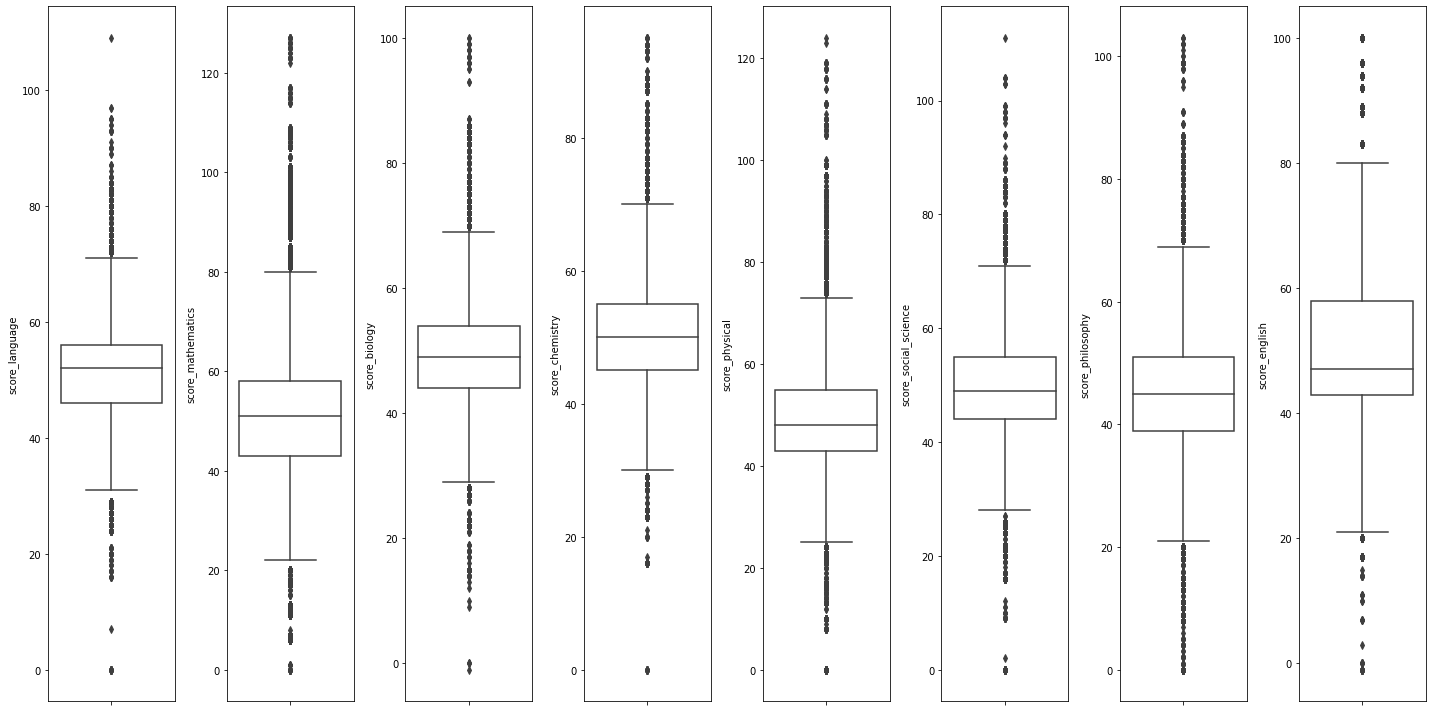


To check pairwise joint distribution of numeric data


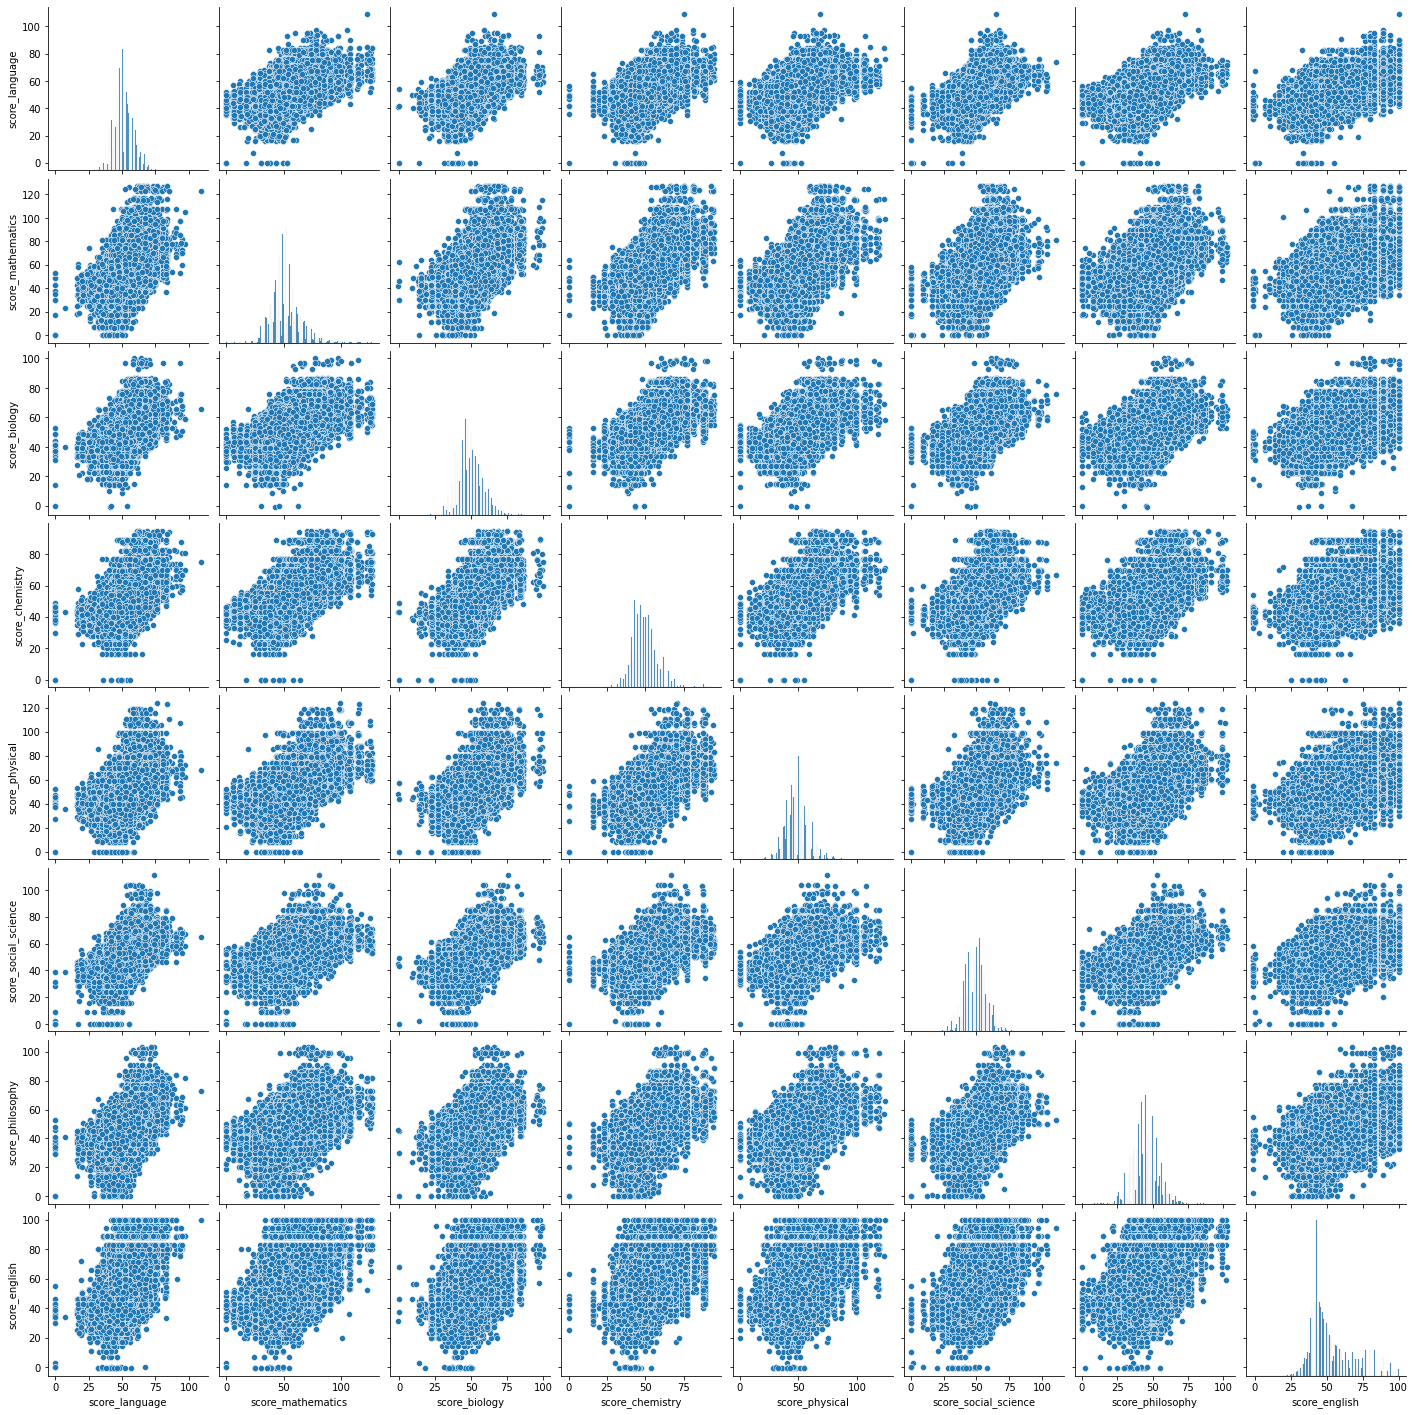

In [84]:
numeric_eda(num)

In [85]:
num

,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english
0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0
1,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0
2,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0
3,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0
4,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0
...,...,...,...,...,...,...,...,...
212005,48.0,54.0,49.0,54.0,70.0,53.0,52.0,58.0
212006,74.0,85.0,68.0,56.0,55.0,60.0,42.0,75.0
212007,52.0,35.0,43.0,29.0,46.0,40.0,34.0,38.0
212008,48.0,50.0,42.0,46.0,45.0,44.0,33.0,43.0


# Some Insights

## 1.  With the help of box plots we can easily that we have some columns with numerical datatype which does have outlier, now we should focus on removing those outliers



## 2.  We can also get some insights throug these pair plots

In [93]:
marks

['score_language',
 'score_mathematics',
 'score_biology',
 'score_chemistry',
 'score_physical',
 'score_social_science',
 'score_philosophy',
 'score_english']

In [94]:
len(marks)

8

# Now lets work on Detecting and Removing Outliers

In [97]:
# Now let's just draw the box plot of those columns which do have outliers individually


outlier_columns = marks
len(outlier_columns)


8

<AxesSubplot:xlabel='score_language'>

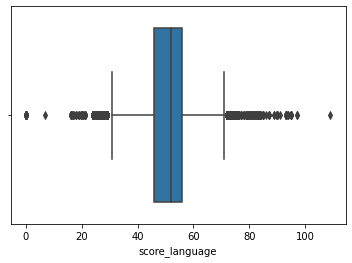

In [98]:
sns.boxplot(x = num[outlier_columns[0]])

<AxesSubplot:xlabel='score_mathematics'>

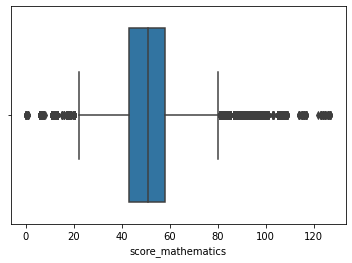

In [99]:
sns.boxplot(x = num[outlier_columns[1]])

<AxesSubplot:xlabel='score_biology'>

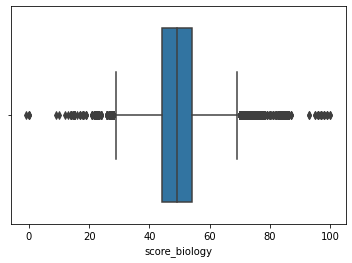

In [100]:
sns.boxplot(x = num[outlier_columns[2]])

<AxesSubplot:xlabel='score_chemistry'>

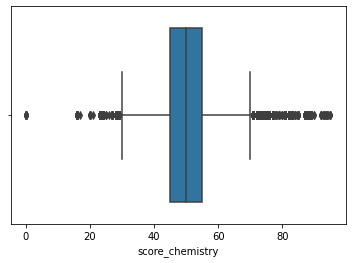

In [101]:
sns.boxplot(x = num[outlier_columns[3]])

<AxesSubplot:xlabel='score_physical'>

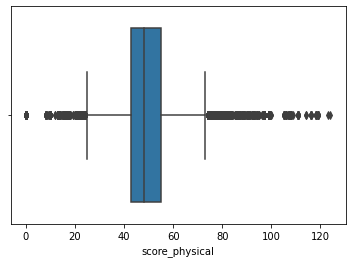

In [102]:
sns.boxplot(x = num[outlier_columns[4]])

<AxesSubplot:xlabel='score_social_science'>

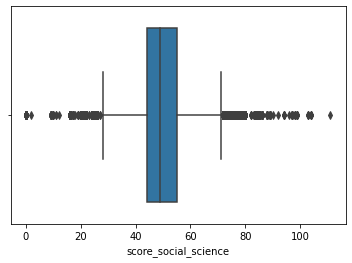

In [103]:
sns.boxplot(x = num[outlier_columns[5]])

<AxesSubplot:xlabel='score_philosophy'>

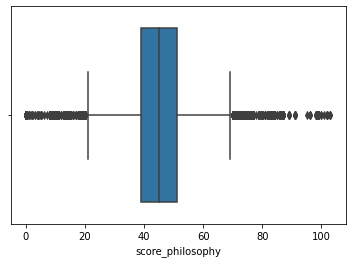

In [104]:
sns.boxplot(x = num[outlier_columns[6]])

<AxesSubplot:xlabel='score_english'>

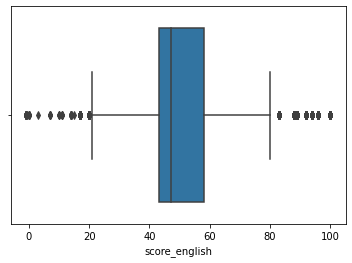

In [105]:
sns.boxplot(x = num[outlier_columns[7]])

In [107]:
len(outlier_columns)

8

In [108]:
# From those box plots we can easily see that these columns do have some outliers 
# One way to deal with outliers are Z-Score

In [111]:
from scipy import stats

In [112]:
num.head()

,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english
0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0
1,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0
2,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0
3,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0
4,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0


In [121]:
z = np.abs(stats.zscore(num))
print(z)

        score_language  score_mathematics  score_biology  score_chemistry  \
0             2.576427           0.703632       1.274680         0.990602   
1             0.457776           0.979547       0.311791         0.206450   
2             0.733966           0.783784       0.067719         0.086744   
3             1.517101           0.463178       1.884861         1.828539   
4             0.457776           0.623481       0.921972         1.762617   
...                ...                ...            ...              ...   
212005        0.457776           0.178033       0.054317         0.445860   
212006        2.985033           2.662727       2.264371         0.685270   
212007        0.071887           1.344844       0.786535         2.546770   
212008        0.457776           0.142572       0.908571         0.511782   
212009        1.131213           1.059699       0.921972         1.283796   

        score_physical  score_social_science  score_philosophy  score_engli

In [114]:
z.shape

(212010, 8)

In [115]:
# In Most of the cases threshold of 3 and -3 is used
# if z score is moer than 3 or less than -3 then that is considered as outliers

In [122]:
threshold = 3
print(np.where(z > 3))

(array([     7,     44,     70, ..., 211999, 211999, 211999], dtype=int64), array([0, 7, 3, ..., 1, 3, 4], dtype=int64))


In [123]:
# Don't get confused by the output
# Output contains 2 arrays first one is row numbers and 2nd array consists of respective column numbers

# like 
print(z)

        score_language  score_mathematics  score_biology  score_chemistry  \
0             2.576427           0.703632       1.274680         0.990602   
1             0.457776           0.979547       0.311791         0.206450   
2             0.733966           0.783784       0.067719         0.086744   
3             1.517101           0.463178       1.884861         1.828539   
4             0.457776           0.623481       0.921972         1.762617   
...                ...                ...            ...              ...   
212005        0.457776           0.178033       0.054317         0.445860   
212006        2.985033           2.662727       2.264371         0.685270   
212007        0.071887           1.344844       0.786535         2.546770   
212008        0.457776           0.142572       0.908571         0.511782   
212009        1.131213           1.059699       0.921972         1.283796   

        score_physical  score_social_science  score_philosophy  score_engli

In [59]:
# Now as we have already got the Z-score of the whole dataframe
# Now let's remove those outliers
# We can do it in one line of code

In [124]:
# let's remove the outliers

num1 = num[(z < 3).all(axis=1)]

In [125]:
num1

,score_language,score_mathematics,score_biology,score_chemistry,score_physical,score_social_science,score_philosophy,score_english
0,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0
1,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0
2,57.0,42.0,50.0,51.0,28.0,46.0,45.0,43.0
3,40.0,46.0,34.0,35.0,45.0,42.0,40.0,43.0
4,48.0,44.0,57.0,65.0,44.0,49.0,43.0,42.0
...,...,...,...,...,...,...,...,...
212005,48.0,54.0,49.0,54.0,70.0,53.0,52.0,58.0
212006,74.0,85.0,68.0,56.0,55.0,60.0,42.0,75.0
212007,52.0,35.0,43.0,29.0,46.0,40.0,34.0,38.0
212008,48.0,50.0,42.0,46.0,45.0,44.0,33.0,43.0


In [126]:
num1.shape

(201728, 8)

In [127]:
df.shape

(212010, 121)

In [130]:
df1=df.loc[:,['score_language',
 'score_mathematics',
 'score_biology',
 'score_chemistry',
 'score_physical',
 'score_social_science',
 'score_philosophy',
 'score_english']].copy()

In [133]:
# Average score in their respective subjects have taken admission to undergraduate program
df1.groupby(['score_language']).mean().T

score_language,0.0,7.0,16.0,17.0,18.0,19.0,20.0,21.0,24.0,25.0,...,86.0,87.0,89.0,90.0,91.0,93.0,94.0,95.0,97.0,109.0
score_mathematics,28.117647,23.0,33.714286,44.909091,30.25,46.000000,39.142857,38.9,39.500000,38.370370,...,75.0,72.000000,86.0,81.000,72.0,80.7,79.0,71.6,91.5,123.0
score_biology,37.235294,40.0,36.714286,39.000000,39.50,39.714286,37.285714,39.0,38.653846,39.185185,...,64.0,58.666667,55.0,62.625,64.0,70.3,76.0,62.8,59.0,66.0
score_chemistry,39.176471,43.0,41.571429,42.181818,40.50,44.000000,40.190476,39.3,41.884615,41.222222,...,65.0,62.333333,73.5,69.625,66.0,66.4,79.0,66.2,75.5,75.0
score_physical,39.000000,36.0,41.714286,43.181818,33.75,38.428571,38.523810,38.6,37.461538,42.111111,...,87.0,63.333333,74.5,65.000,65.0,70.2,72.5,62.2,67.0,68.0
score_social_science,6.411765,39.0,38.714286,32.181818,32.50,42.285714,38.476190,39.9,37.500000,37.037037,...,69.0,65.666667,61.0,59.625,61.0,66.4,64.5,64.6,62.5,65.0
score_philosophy,33.529412,41.0,34.571429,33.909091,31.75,34.714286,33.142857,38.2,35.461538,36.740741,...,67.0,66.666667,71.5,64.375,55.0,57.6,64.5,61.4,71.5,73.0
score_english,30.411765,34.0,37.000000,39.090909,32.75,41.714286,39.095238,41.7,37.538462,38.185185,...,83.0,100.000000,80.0,93.125,60.0,81.8,87.0,86.0,89.0,100.0


<AxesSubplot:>

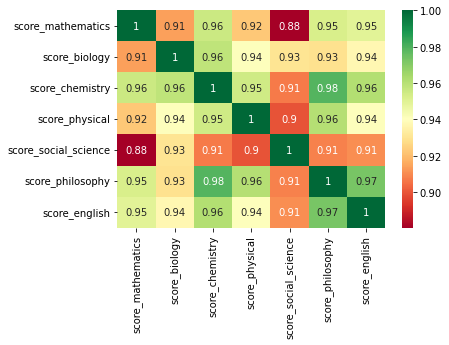

In [135]:
# Subjects Correlation
import seaborn as sns
sns.heatmap(df1.groupby(['score_language']).mean().corr(),annot=True,cmap='RdYlGn')